<a href="https://colab.research.google.com/github/https-deeplearning-ai/tensorflow-1-public/blob/master/C3/W3/ungraded_labs/C3_W3_Lab_6_sarcasm_with_1D_convolutional.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ungraded Lab: Training a Sarcasm Detection Model using a Convolution Layer

You will be doing the same steps here as the previous lab but will be using a convolution layer instead. As usual, try tweaking the parameters and observe how it affects the results. 


In [1]:
# Install this package to use Colab's GPU for training
!apt install --allow-change-held-packages libcudnn8=8.4.1.50-1+cuda11.6

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following packages will be REMOVED:
  libcudnn8-dev
The following held packages will be changed:
  libcudnn8
The following packages will be upgraded:
  libcudnn8
1 upgraded, 0 newly installed, 1 to remove and 27 not upgraded.
Need to get 420 MB of archives.
After this operation, 1,622 MB disk space will be freed.
Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  libcudnn8 8.4.1.50-1+cuda11.6 [420 MB]
Fetched 420 MB in 16s (26.0 MB/s)
(Reading database ... 123942 files and directories currently installed.)
Removing libcudnn8-dev (8.1.1.33-1+cuda11.2) ...
update-alternatives: removing manually selected alternative - switching libcudnn to auto mode
(Reading database ... 123919 files and directories currently installed.)
Prepar

## Download the Dataset

In [2]:
# Download the dataset
!wget -P data/ https://storage.googleapis.com/tensorflow-1-public/course3/sarcasm.json

--2022-10-28 21:25:49--  https://storage.googleapis.com/tensorflow-1-public/course3/sarcasm.json
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.107.128, 173.194.202.128, 74.125.20.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.107.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5643545 (5.4M) [application/json]
Saving to: ‘data/sarcasm.json’

sarcasm.json        100%[===================>]   5.38M  --.-KB/s    in 0.1s    

2022-10-28 21:25:49 (46.1 MB/s) - ‘data/sarcasm.json’ saved [5643545/5643545]



In [3]:
import json

# Load the JSON file
with open("./data/sarcasm.json", "r") as f:
    datastore = json.load(f)

# Initialize the lists
sentences = []
labels = []

# Collect sentences and labels into the lists
for item in datastore:
    sentences.append(item["headline"])
    labels.append(item["is_sarcastic"])

## Split the Dataset

In [4]:
training_size = 20000

# Split the sentences
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]

# Split the labels
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

## Data preprocessing

In [17]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

vocab_size = 10000
max_length = 120
trunc_type = "post"
padding_type = "post"
oov_tok = "<OOV>"

# Initialize the Tokenizer class
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)

# Generate the word index dictionary
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index

# Generate and pad the training sequences
training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(
    training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type
)

# Generate and pad the testing sequences
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(
    testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type
)

# Convert the labels lists into numpy arrays
training_labels = np.array(training_labels)
testing_labels = np.array(testing_labels)

## Build and Compile the Model

In [18]:
import tensorflow as tf

# Parameters
embedding_dim = 16
filters = 128
kernel_size = 5
dense_dim = 6

# Model Definition with Conv1D
model_conv = tf.keras.Sequential(
    [
        tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
        tf.keras.layers.Conv1D(filters, kernel_size, activation="relu"),
        # tf.keras.layers.GlobalMaxPooling1D(),  # doesnt perform as well
        tf.keras.layers.GlobalAveragePooling1D(),
        # tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(dense_dim, activation="relu"),
        tf.keras.layers.Dense(1, activation="sigmoid"),
    ]
)

# Set the training parameters
model_conv.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Print the model summary
model_conv.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 120, 16)           160000    
                                                                 
 conv1d_6 (Conv1D)           (None, 116, 128)          10368     
                                                                 
 global_average_pooling1d_5   (None, 128)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_10 (Dense)            (None, 6)                 774       
                                                                 
 dense_11 (Dense)            (None, 1)                 7         
                                                                 
Total params: 171,149
Trainable params: 171,149
Non-trainable params: 0
________________________________________________

## Train the Model

In [19]:
NUM_EPOCHS = 20
BATCH_SIZE = 512

# Train the model
history_conv = model_conv.fit(
    training_padded,
    training_labels,
    epochs=NUM_EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(testing_padded, testing_labels),
)

Epoch 1/20
40/40 [==============================] - 7s 153ms/step - loss: 0.6868 - accuracy: 0.5548 - val_loss: 0.6841 - val_accuracy: 0.5633
Epoch 2/20
40/40 [==============================] - 6s 149ms/step - loss: 0.6796 - accuracy: 0.5603 - val_loss: 0.6682 - val_accuracy: 0.5633
Epoch 3/20
40/40 [==============================] - 6s 148ms/step - loss: 0.6365 - accuracy: 0.5971 - val_loss: 0.6070 - val_accuracy: 0.6821
Epoch 4/20
40/40 [==============================] - 6s 149ms/step - loss: 0.5606 - accuracy: 0.7500 - val_loss: 0.5528 - val_accuracy: 0.7725
Epoch 5/20
40/40 [==============================] - 9s 225ms/step - loss: 0.4941 - accuracy: 0.8220 - val_loss: 0.5234 - val_accuracy: 0.7733
Epoch 6/20
40/40 [==============================] - 6s 149ms/step - loss: 0.4437 - accuracy: 0.8621 - val_loss: 0.4942 - val_accuracy: 0.8110
Epoch 7/20
40/40 [==============================] - 6s 151ms/step - loss: 0.4061 - accuracy: 0.8906 - val_loss: 0.4847 - val_accuracy: 0.8140
Epoch 

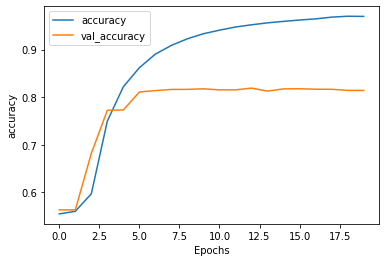

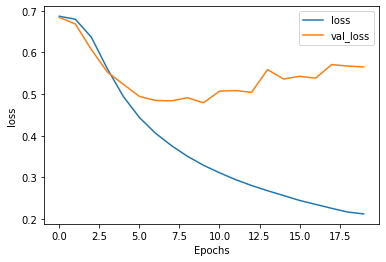

In [20]:
import matplotlib.pyplot as plt

# Plot Utility
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history["val_" + string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, "val_" + string])
    plt.show()


# Plot the accuracy and loss history
plot_graphs(history_conv, "accuracy")
plot_graphs(history_conv, "loss")